# prepare

In [ ]:
!git clone https://github.com/BBillot/lab2im


fatal: destination path 'lab2im' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/Project-MONAI/tutorials

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [ ]:
!pip install monai -q

In [ ]:
data_example_path="/content/lab2im/tutorials/data_example"
import os
import numpy as np
import torch
os.listdir(data_example_path)
import glob
# Get all .npy files in the directory
npy_files = glob.glob(os.path.join(data_example_path, "*.npy")) # Use os.path.join for better path handling

if not npy_files:
    print(f"No .npy files found in {data_example_path}.")
else:
    print(f"Found {len(npy_files)} .npy files. Loading and printing their contents:")
    print("-" * 30)
    for file_path in npy_files: # Renamed 'file' to 'file_path' for clarity
        print(f"Loading and printing content of: {os.path.basename(file_path)}")
        array = np.load(file_path) # Corrected: load the individual file_path
        print(f"Array.shape: {array.shape}")
        print(array)
        print("\n" + "=" * 50 + "\n") # Separator for better readability between arrays

Found 5 .npy files. Loading and printing their contents:
------------------------------
Loading and printing content of: segmentation_labels.npy
Array.shape: (26,)
[ 0 14 15 16  0  0  0  0  0  0  2  3  4  5  7  8 10 11 12 13 17 18 26 28
  0 31]


Loading and printing content of: generation_classes.npy
Array.shape: (26,)
[ 0  3  3  4  3  3 17 16 15 14  1  2  3  3  1  2  5  6  7  8  9 10 11 12
  3 13]


Loading and printing content of: generation_labels.npy
Array.shape: (26,)
[  0  14  15  16  24  72  85 165 258 259   2   3   4   5   7   8  10  11
  12  13  17  18  26  28  30  31]


Loading and printing content of: prior_means.npy
Array.shape: (2, 18)
[[15.         98.00008392 59.60008087 30.18745666 78.79997559 84.60007629
  71.19981384 77.19995117 95.60005188 59.60008087 60.99995422 65.40006714
  90.20001526 49.2000061  82.35294118 82.35294118 58.82352941 75.19997253]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.

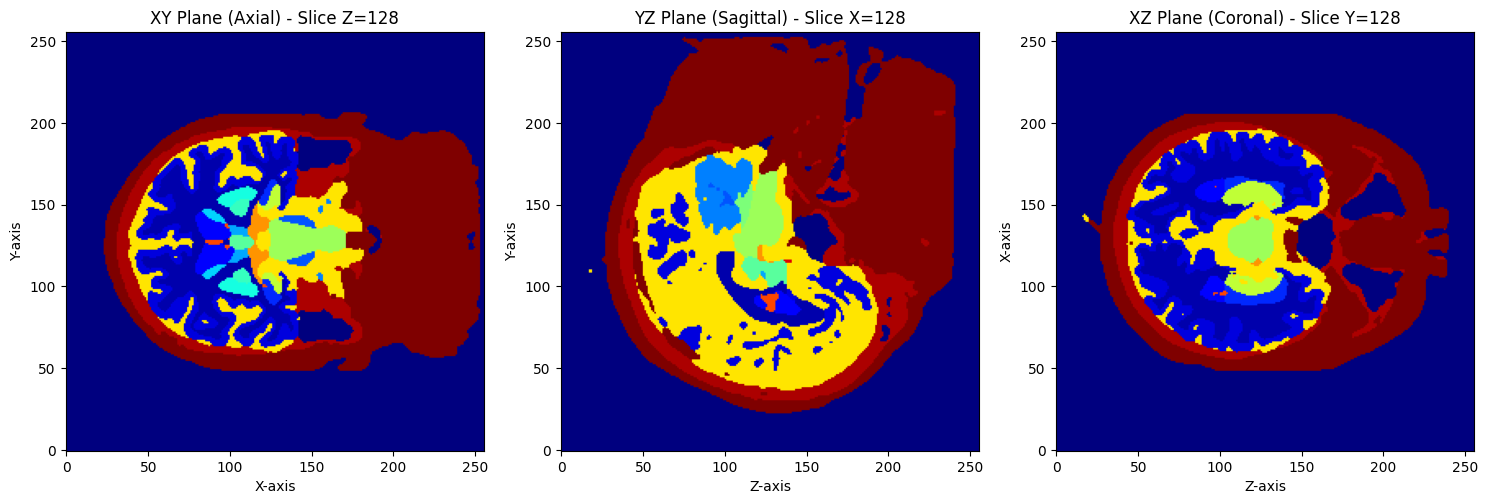

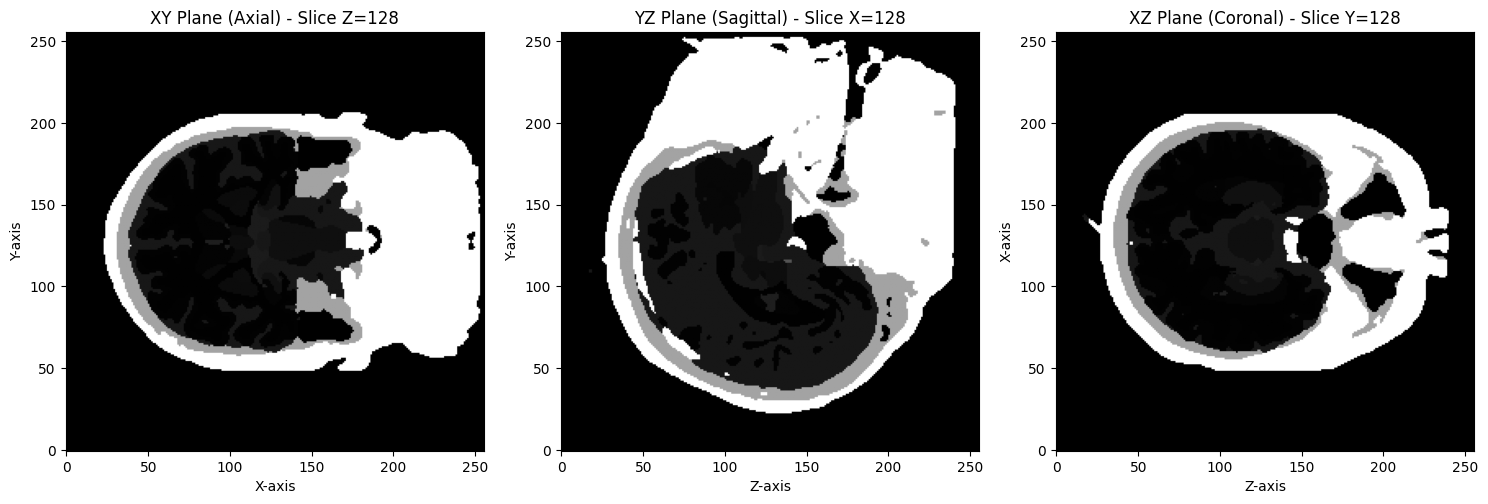

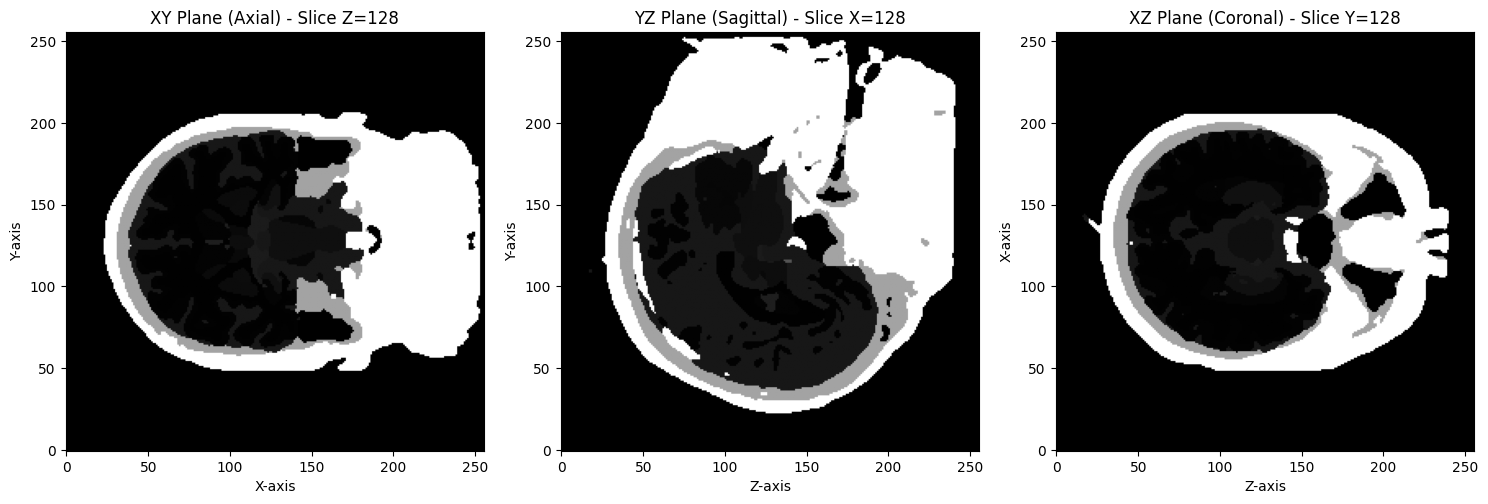

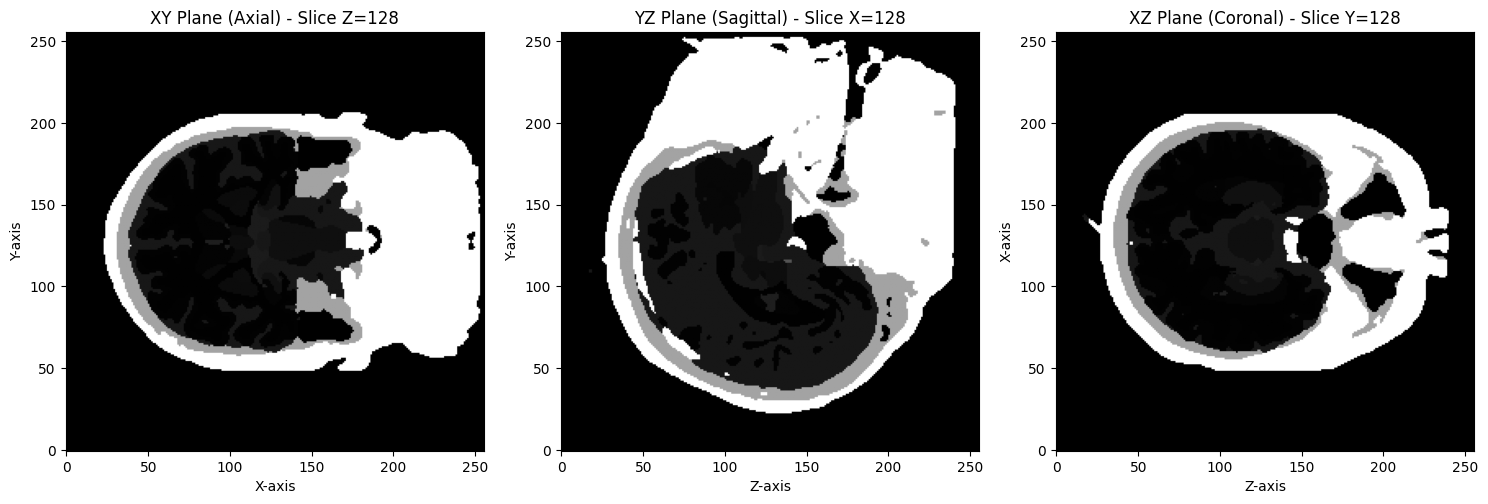

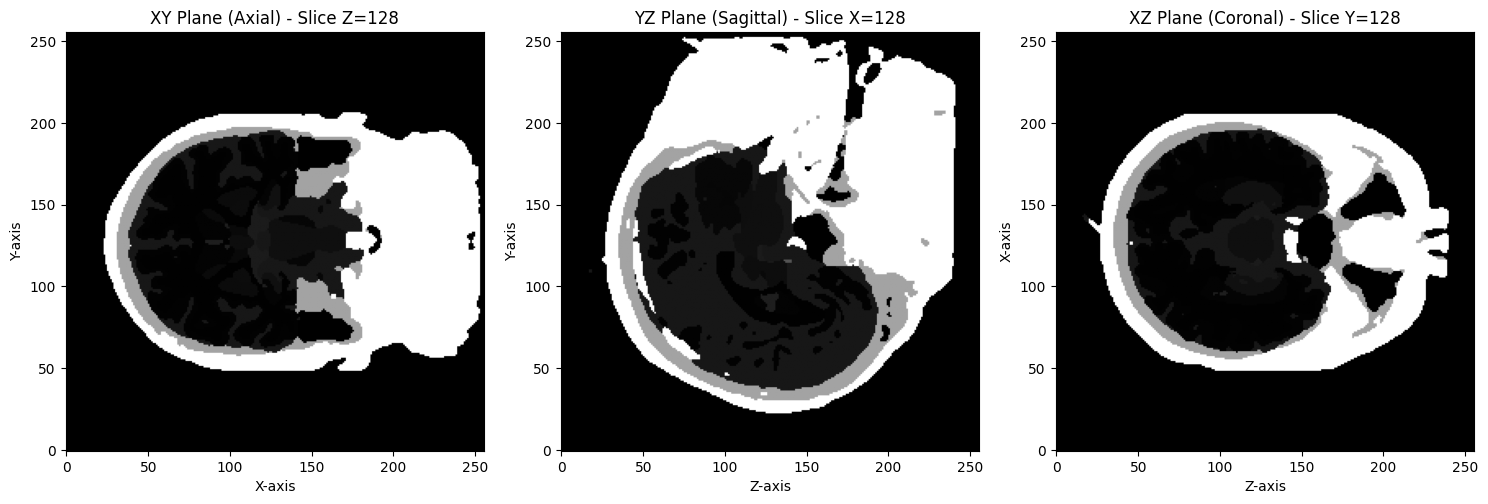

In [ ]:
import nibabel as nib
import numpy as np
brain_label_map_path=os.path.join(data_example_path,"brain_label_map.nii.gz")
brain_label_map=nib.load(brain_label_map_path).get_fdata()
labels=np.unique(brain_label_map)
import matplotlib.pyplot as plt
def utils_show3d(images,cmap="gray"):
  if isinstance(images,torch.Tensor):
    return utils_show3d(images.numpy(),cmap)
  if len(images.shape)>3:
    return utils_show3d(images[0],cmap)
  labels=np.unique(images)
  # brain_label_map=images.copy()
  # for i in range(len(labels)):
  #   brain_label_map[brain_label_map==labels[i]]=i
  brain_label_map=images.copy()

  dim_x, dim_y, dim_z = brain_label_map.shape

  # Calculate the middle slices
  mid_x = dim_x // 2
  mid_y = dim_y // 2
  mid_z = dim_z // 2

  # Create the figure and subplots
  fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns

  # XY plane (axial view)
  axes[0].imshow(brain_label_map[:, :, mid_z], cmap=cmap, origin='lower')
  axes[0].set_title(f'XY Plane (Axial) - Slice Z={mid_z}')
  axes[0].set_xlabel('X-axis')
  axes[0].set_ylabel('Y-axis')

  # YZ plane (sagittal view)
  axes[1].imshow(brain_label_map[mid_x, :, :], cmap=cmap, origin='lower')
  axes[1].set_title(f'YZ Plane (Sagittal) - Slice X={mid_x}')
  axes[1].set_xlabel('Z-axis') # Note: For YZ, Z is typically on the x-axis for display
  axes[1].set_ylabel('Y-axis')

  # XZ plane (coronal view)
  axes[2].imshow(brain_label_map[:, mid_y, :], cmap=cmap, origin='lower')
  axes[2].set_title(f'XZ Plane (Coronal) - Slice Y={mid_y}')
  axes[2].set_xlabel('Z-axis') # Note: For XZ, Z is typically on the x-axis for display
  axes[2].set_ylabel('X-axis')

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()
def utils_show3d_seg(images):
  labels=np.unique(images)
  if isinstance(images,torch.Tensor):
    return utils_show3d_seg(images.numpy())
  if len(images.shape)>3:
    return utils_show3d_seg(images[0])
  # brain_label_map=
  brain_label_map=images.copy()
  for i in range(len(labels)):
    brain_label_map[brain_label_map==labels[i]]=i
  return utils_show3d(brain_label_map,cmap="jet")
utils_show3d_seg(brain_label_map)
utils_show3d(brain_label_map)
utils_show3d(torch.tensor(brain_label_map))
utils_show3d(torch.tensor(brain_label_map)[None,...])
utils_show3d(torch.tensor(brain_label_map)[None,...][None,...])


# stand alone implementation (Just run this is enough)

In [ ]:
import monai.transforms as mt
import numpy as np
import torch
import os
import nibabel as nib # For creating dummy NIfTI
import matplotlib.pyplot as plt # For visualization
from dataclasses import dataclass
from typing import Literal, Optional, Dict, Any
import warnings

# --- 1. Your Custom RandomIntensityFromLabels Transform and Config (from previous steps) ---
# Make sure these classes are defined and working correctly as per our last interaction.
# I'm including them here for completeness but assuming they are accessible.

@dataclass
class SamplingConfig:
    prior_mean_distribution: Literal["uniform", "normal"] = "uniform"
    prior_mean_parameters: Optional[np.ndarray] = None
    prior_std_distribution: Literal["uniform", "normal"] = "uniform"
    prior_std_parameters: Optional[np.ndarray] = None
    _default_mean_middle: float = 125.0
    _default_mean_range: float = 100.0
    _default_std_middle: float = 15.0
    _default_std_range: float = 10.0

    def __post_init__(self):
        assert self.prior_mean_distribution in ["uniform", "normal"]
        assert self.prior_std_distribution in ["uniform", "normal"]

    def get_default_mean_params(self, num_labels: int) -> np.ndarray:
        if self.prior_mean_distribution == "uniform":
            lows = np.full(num_labels, self._default_mean_middle - self._default_mean_range / 2)
            highs = np.full(num_labels, self._default_mean_middle + self._default_mean_range / 2)
            return np.array([lows, highs])
        else:
            means = np.full(num_labels, self._default_mean_middle)
            stds = np.full(num_labels, self._default_mean_range)
            return np.array([means, stds])

    def get_default_std_params(self, num_labels: int) -> np.ndarray:
        if self.prior_std_distribution == "uniform":
            lows = np.full(num_labels, self._default_std_middle - self._default_std_range / 2)
            highs = np.full(num_labels, self._default_std_middle + self._default_std_range / 2)
            return np.array([lows, highs])
        else:
            means = np.full(num_labels, self._default_std_middle)
            stds = np.full(num_labels, self._default_std_range)
            return np.array([means, stds])

def _sample_from_prior(prior_parameters: np.ndarray, distribution_type: Literal["uniform", "normal"]) -> np.ndarray:
    assert isinstance(prior_parameters, np.ndarray)
    assert len(prior_parameters.shape) == 2
    assert prior_parameters.shape[0] == 2
    assert distribution_type in ["uniform", "normal"]

    distribution_map: Dict[str, Any] = {
        "uniform": np.random.uniform,
        "normal": np.random.normal
    }
    distribution_func = distribution_map[distribution_type]

    K = prior_parameters.shape[1]
    sampled_values = np.zeros(K)

    for i in range(K):
        param1 = prior_parameters[0, i]
        param2 = prior_parameters[1, i]

        if distribution_type == "uniform":
            low = min(param1, param2)
            high = max(param1, param2)
            sampled_values[i] = distribution_func(low, high)
        elif distribution_type == "normal":
            sampled_values[i] = distribution_func(loc=param1, scale=param2)

    return sampled_values

class RandomIntensityFromLabels(mt.Transform):
    def __init__(
        self,
        label_key: str = "label",
        image_key: str = "image",
        config: Optional[SamplingConfig] = None,
        output_dtype: torch.dtype = torch.float32,
        clamp_output_min: Optional[float] = 0.0,
        clamp_output_max: Optional[float] = None,
        p: float = 1.0,
    ):
        super().__init__()
        self.label_key = label_key
        self.image_key = image_key
        self.config = config if config is not None else SamplingConfig()
        self.output_dtype = output_dtype
        self.clamp_output_min = clamp_output_min
        self.clamp_output_max = clamp_output_max
        self.p = p

    def __call__(self, data: Dict[str, Any]) -> Dict[str, Any]:
        if np.random.rand() >= self.p:
            return data

        if self.label_key not in data:
            raise ValueError(f"Label map key '{self.label_key}' not found in input data.")

        original_label_map = data[self.label_key]

        if isinstance(original_label_map, torch.Tensor):
            if original_label_map.ndim > 3 and original_label_map.shape[0] == 1:
                brain_label_map_np = original_label_map.squeeze(0).cpu().numpy()
            else:
                brain_label_map_np = original_label_map.cpu().numpy()
        else:
            brain_label_map_np = original_label_map

        if not np.issubdtype(brain_label_map_np.dtype, np.integer):
            warnings.warn(f"Label map dtype {brain_label_map_np.dtype} is not integer. Converting to np.int32.")
            brain_label_map_np = brain_label_map_np.astype(np.int32)

        unique_labels_raw = np.unique(brain_label_map_np)
        unique_labels_for_sampling = unique_labels_raw[unique_labels_raw != 0] if 0 in unique_labels_raw else unique_labels_raw

        if len(unique_labels_for_sampling) == 0:
            warnings.warn("No non-zero labels found for intensity sampling. Output intensity map will be filled with min_clamp.")
            output_array = np.full(brain_label_map_np.shape, self.clamp_output_min or 0.0, dtype=self.output_dtype)
            data[self.image_key] = torch.from_numpy(output_array).unsqueeze(0).to(self.output_dtype)
            return data

        label_to_index = {label: i for i, label in enumerate(unique_labels_for_sampling)}
        num_labels_for_sampling = len(unique_labels_for_sampling)

        prior_mean_params = self.config.prior_mean_parameters
        if prior_mean_params is None:
            prior_mean_params = self.config.get_default_mean_params(num_labels_for_sampling)
        else:
            if prior_mean_params.ndim != 2:
                raise ValueError(f"prior_mean_parameters must be a 2D array. Got {prior_mean_params.ndim} dimensions and shape {prior_mean_params.shape}.")
            if prior_mean_params.shape[0] != 2:
                raise ValueError(f"prior_mean_parameters must have 2 rows. Got shape {prior_mean_params.shape}.")
            if prior_mean_params.shape[1] != num_labels_for_sampling:
                 raise ValueError(f"prior_mean_parameters must have {num_labels_for_sampling} columns for {num_labels_for_sampling} unique labels "
                                  f"({unique_labels_for_sampling}). Got shape {prior_mean_params.shape}.")

        prior_std_params = self.config.prior_std_parameters
        if prior_std_params is None:
            prior_std_params = self.config.get_default_std_params(num_labels_for_sampling)
        else:
            if prior_std_params.ndim != 2:
                raise ValueError(f"prior_std_parameters must be a 2D array. Got {prior_std_params.ndim} dimensions and shape {prior_std_params.shape}.")
            if prior_std_params.shape[0] != 2:
                raise ValueError(f"prior_std_parameters must have 2 rows. Got shape {prior_std_params.shape}.")
            if prior_std_params.shape[1] != num_labels_for_sampling:
                raise ValueError(f"prior_std_parameters must have {num_labels_for_sampling} columns for {num_labels_for_sampling} unique labels "
                                 f"({unique_labels_for_sampling}). Got shape {prior_std_params.shape}.")

        sampled_means_for_labels = _sample_from_prior(prior_mean_params, self.config.prior_mean_distribution)
        sampled_stds_for_labels = _sample_from_prior(prior_std_params, self.config.prior_std_distribution)

        if np.any(sampled_stds_for_labels <= 0):
            raise ValueError(f"Sampled standard deviations must be greater than 0. Got: {sampled_stds_for_labels}")

        intensity_map_np = np.zeros_like(brain_label_map_np, dtype=np.float32)

        for label_val in unique_labels_for_sampling:
            idx = label_to_index[label_val]
            mean_for_this_label = sampled_means_for_labels[idx]
            std_for_this_label = sampled_stds_for_labels[idx]

            mask = (brain_label_map_np == label_val)
            num_voxels = np.sum(mask)

            if num_voxels > 0:
                sampled_intensities = np.random.normal(loc=mean_for_this_label, scale=std_for_this_label, size=num_voxels)

                if self.clamp_output_min is not None:
                    sampled_intensities[sampled_intensities < self.clamp_output_min] = self.clamp_output_min
                if self.clamp_output_max is not None:
                    sampled_intensities[sampled_intensities > self.clamp_output_max] = self.clamp_output_max

                intensity_map_np[mask] = sampled_intensities

        if 0 in unique_labels_raw:
             intensity_map_np[brain_label_map_np == 0] = self.clamp_output_min if self.clamp_output_min is not None else 0.0

        data[self.image_key] = torch.from_numpy(intensity_map_np).unsqueeze(0).to(self.output_dtype)
        return data



Train pipeline created with config: GlobalTransformConfig(image_keys='synth_image', label_keys='label', patch_size=(192, 192, 192), val_patch_size=None, k_divisible=16, interp_mode_image='bilinear', interp_mode_label='nearest', output_dtype=torch.float32, is_training_mode=True, sampling_config=SamplingConfig(prior_mean_distribution='uniform', prior_mean_parameters=None, prior_std_distribution='uniform', prior_std_parameters=None, _default_mean_middle=125.0, _default_mean_range=100.0, _default_std_middle=15.0, _default_std_range=10.0), intensity_clamp_min=0.0, intensity_clamp_max=255.0, all_keys=['synth_image', 'label'])
Validation pipeline created with config: GlobalTransformConfig(image_keys='synth_image', label_keys='label', patch_size=(192, 192, 192), val_patch_size=None, k_divisible=16, interp_mode_image='bilinear', interp_mode_label='nearest', output_dtype=torch.float32, is_training_mode=False, sampling_config=SamplingConfig(prior_mean_distribution='uniform', prior_mean_parameters

<ipython-input-17-21fba0fd9f89>:116: UserWarning: Label map dtype float32 is not integer. Converting to np.int32.
  warnings.warn(f"Label map dtype {brain_label_map_np.dtype} is not integer. Converting to np.int32.")


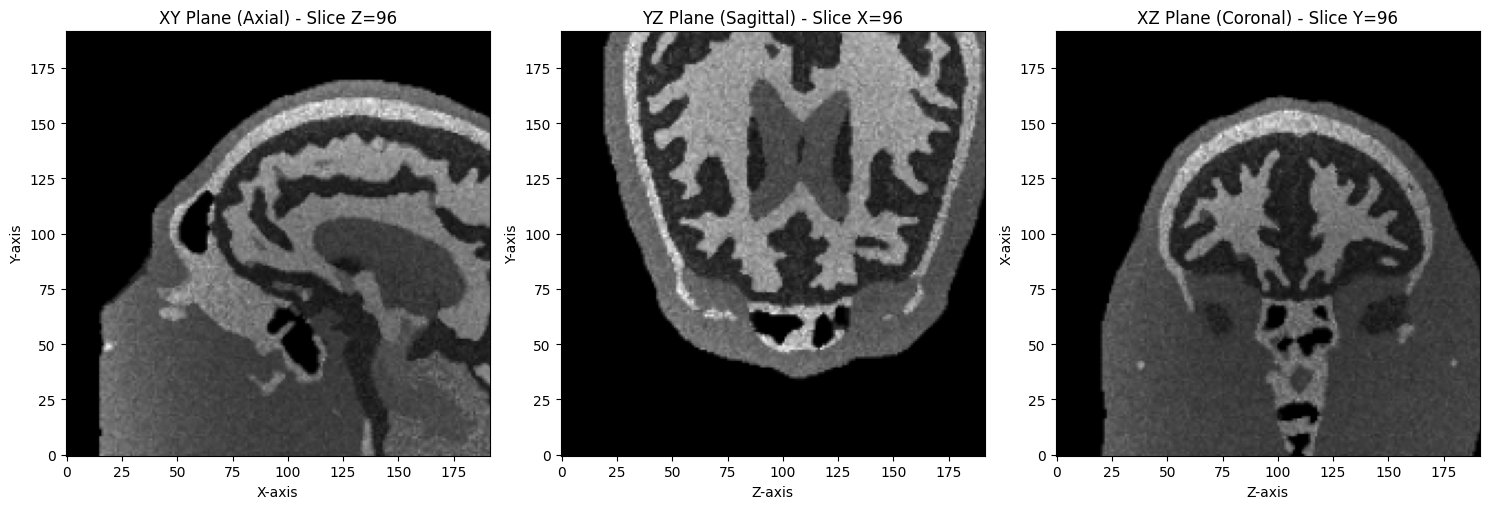

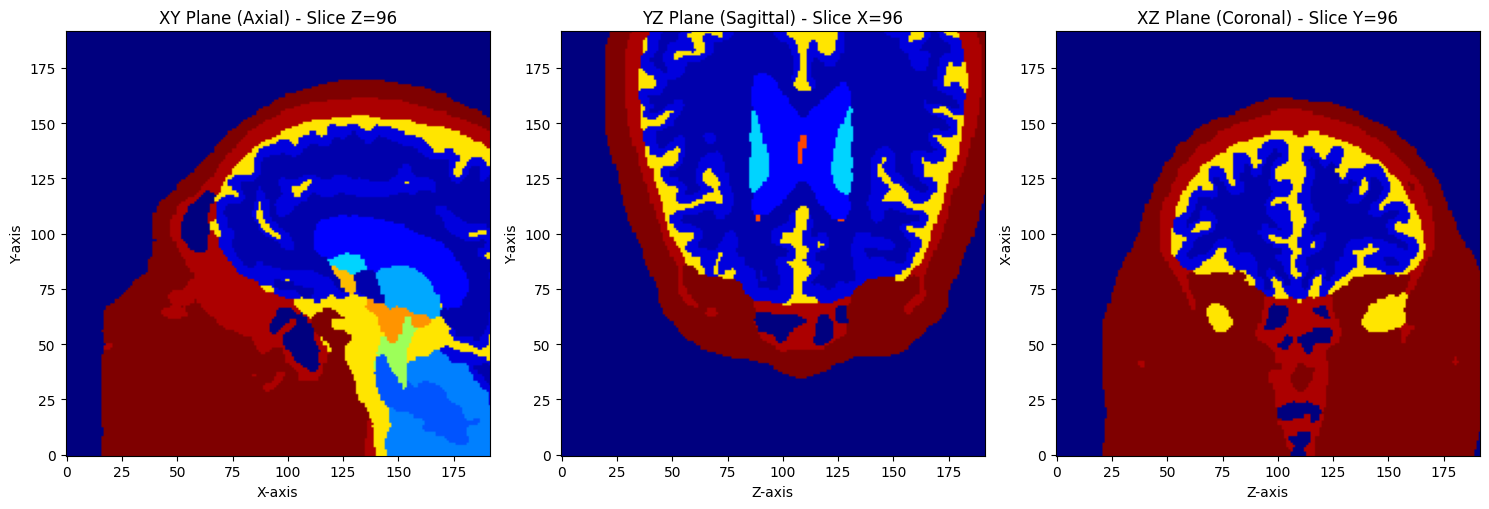

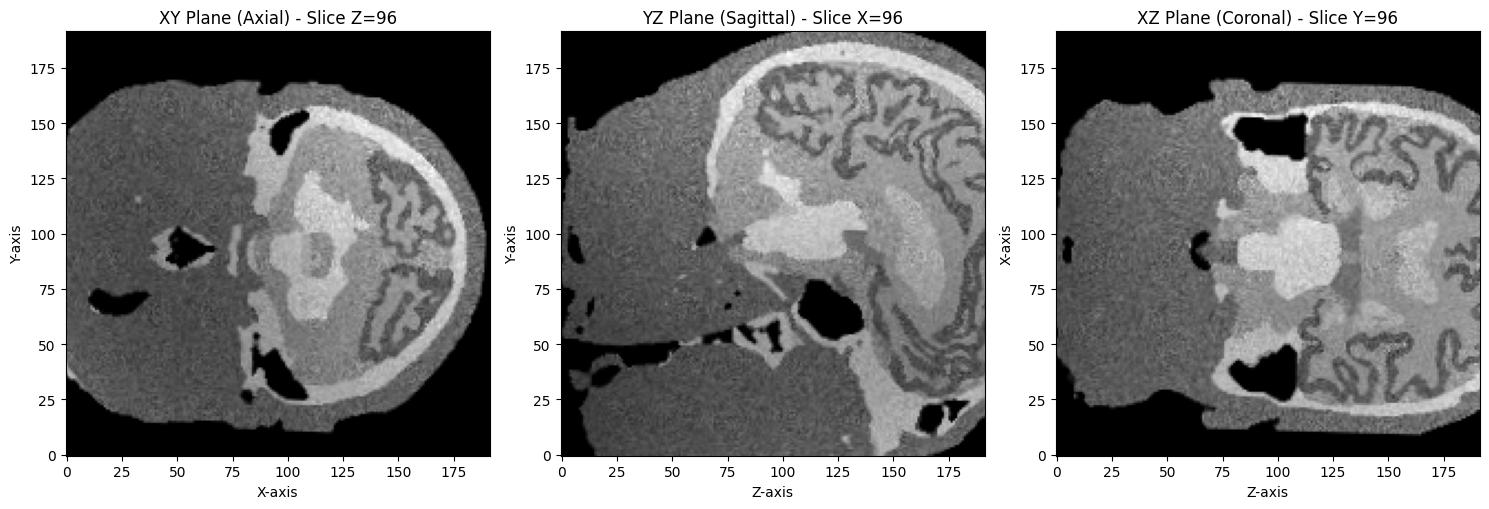

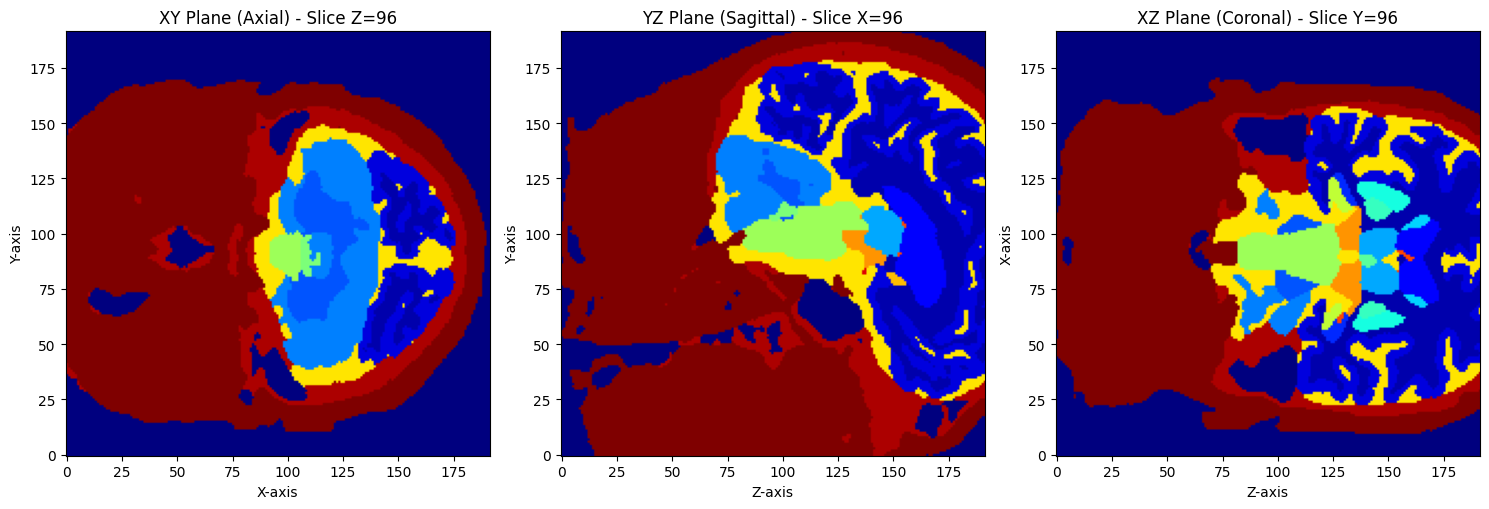

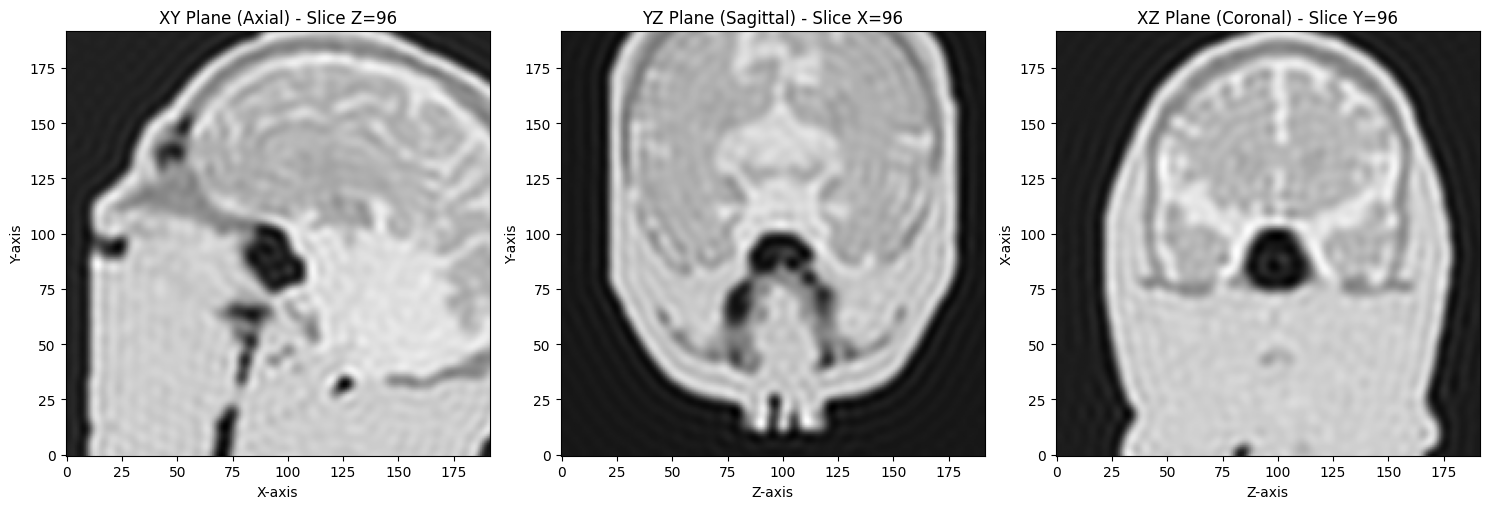

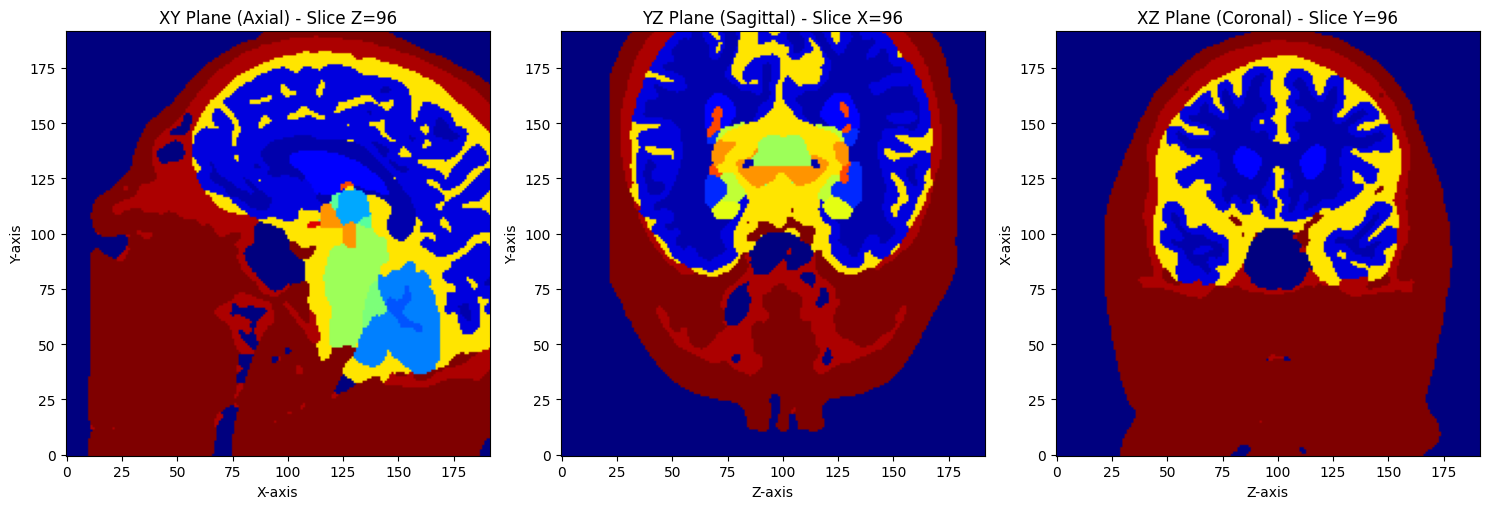

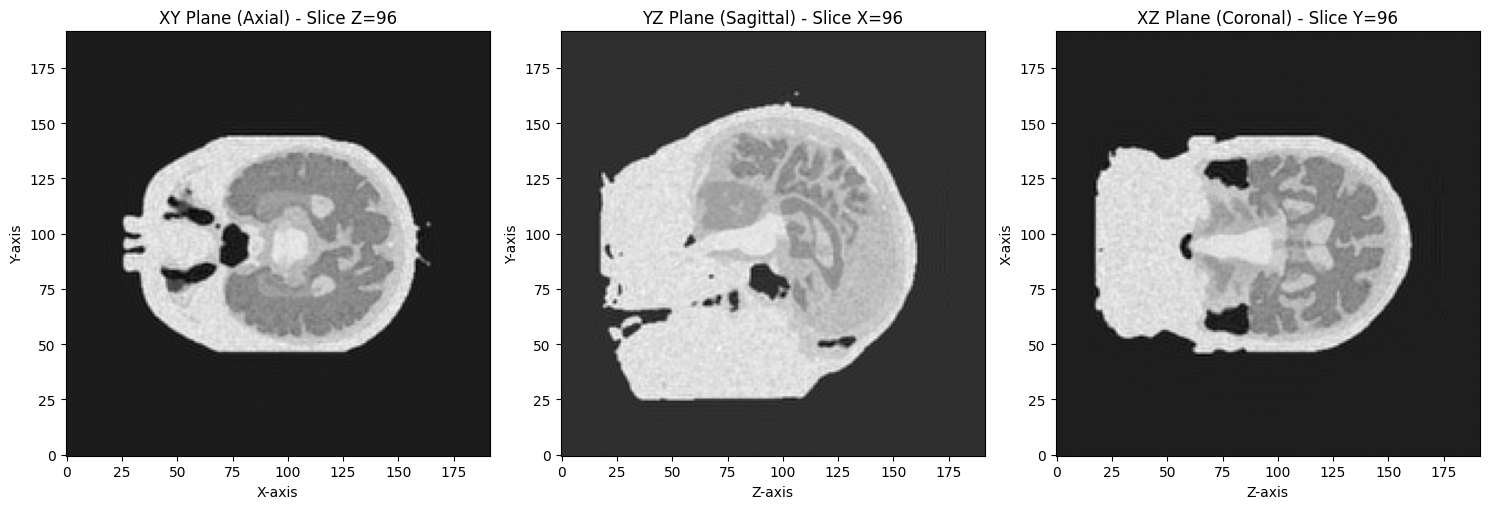

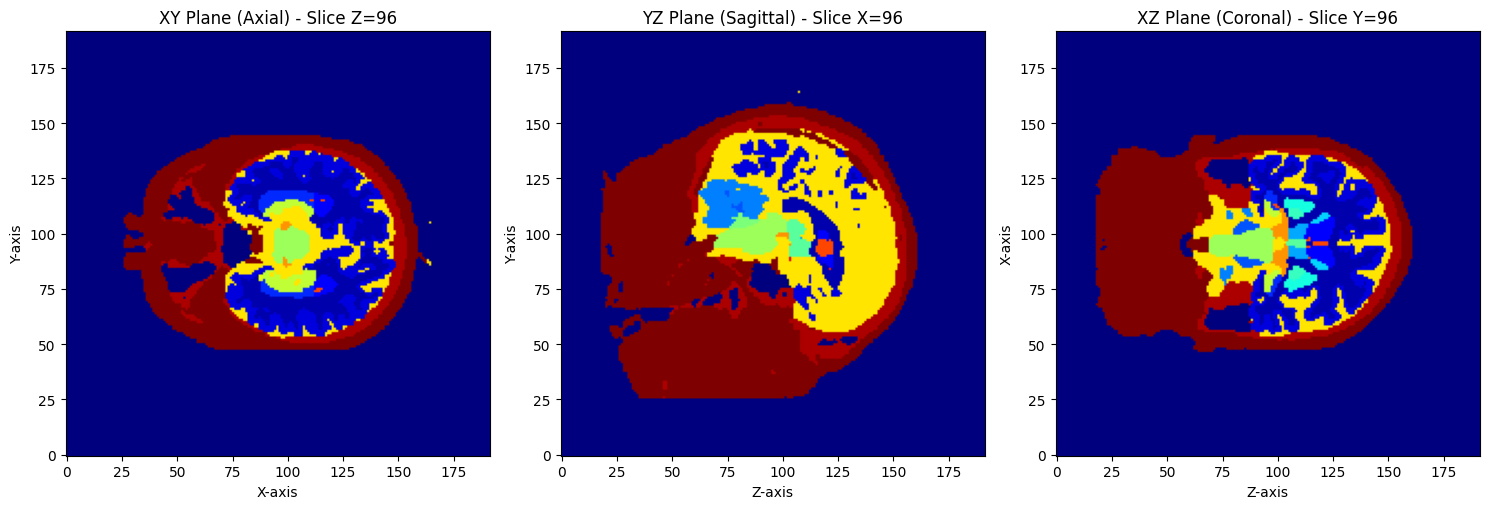

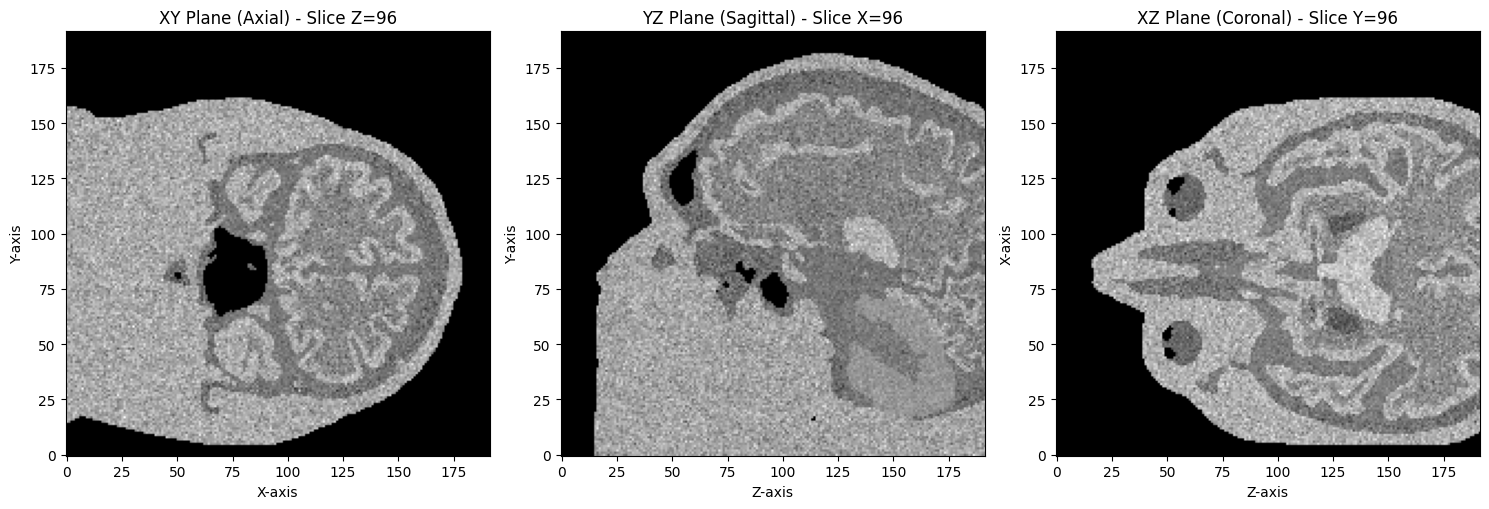

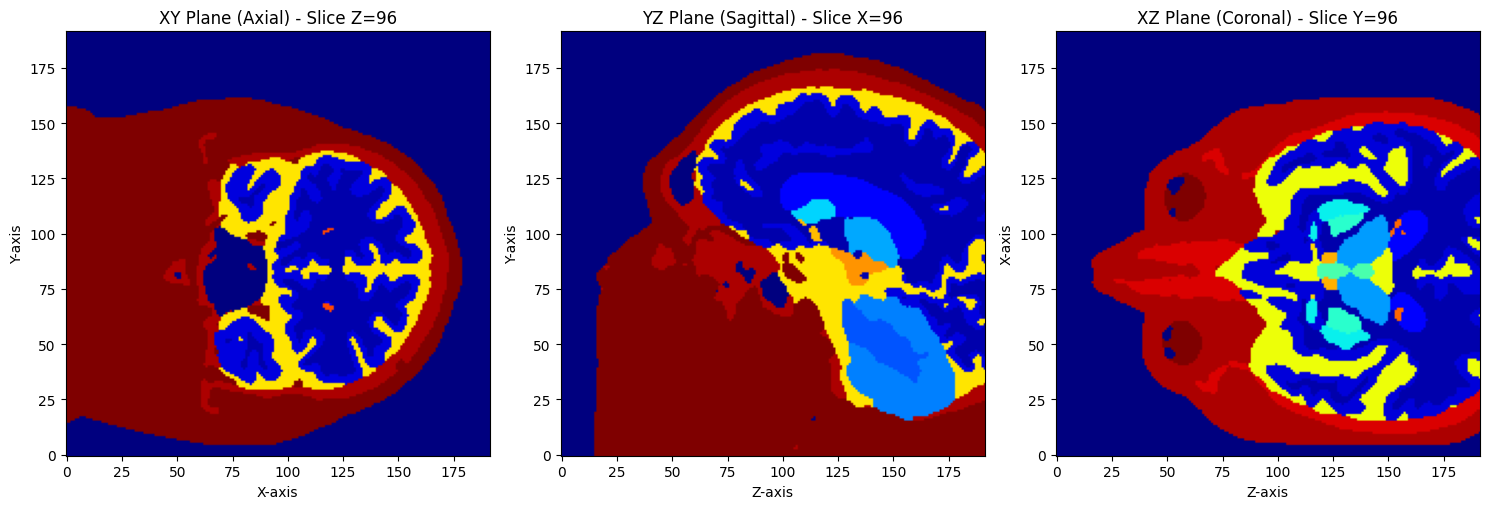

In [ ]:
import monai.transforms as mt
import numpy as np
import torch
import os
import nibabel as nib # For creating dummy NIfTI
import matplotlib.pyplot as plt # For visualization
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Union, Any, Dict, Literal # Added Literal for SamplingConfig

# --- Make sure RandomIntensityFromLabels and SamplingConfig are defined as in your original code ---
# (Assuming they are already defined in your environment from the previous script)
# For brevity, I'm not re-pasting them here, but they are dependencies.

@dataclass
class GlobalTransformConfig:
    image_keys: str = "synth_image"
    label_keys: str = "label"
    patch_size: Tuple[int, int, int] = (192, 192, 192)
    val_patch_size: Optional[Tuple[int, int, int]] = (256, 256, 256) # Can be None
    k_divisible: Union[int, Tuple[int, int, int]] = 16
    interp_mode_image: str = "bilinear"
    interp_mode_label: str = "nearest"
    output_dtype: torch.dtype = torch.float32
    is_training_mode: bool = True
    # For RandomIntensityFromLabels, if you want to configure it globally too
    sampling_config: SamplingConfig = field(default_factory=SamplingConfig)
    intensity_clamp_min: Optional[float] = 0.0
    intensity_clamp_max: Optional[float] = 255.0
    # For data loading, though this might be better in a separate data config
    # For now, including as it was a global var used near the transform
    # brain_label_map_path: Optional[str] = None # Example, if you load data using the config

    all_keys: List[str] = field(init=False)

    def __post_init__(self):
        self.all_keys = [self.image_keys, self.label_keys]
        if isinstance(self.output_dtype, str): # Allow string definition for dtype e.g. "float32"
            if self.output_dtype == "float32":
                self.output_dtype = torch.float32
            elif self.output_dtype == "int32":
                self.output_dtype = torch.int32
            # Add more dtypes as needed
            else:
                raise ValueError(f"Unsupported output_dtype string: {self.output_dtype}")


# --- Instantiate the GlobalTransformConfig ---
# You can modify these defaults when creating an instance
g_config = GlobalTransformConfig(
    is_training_mode=True,
    # Example: if you want to set specific sampling params here
    # sampling_config=SamplingConfig(prior_mean_distribution="normal")
)

# --- Build the MONAI Compose Pipeline using the config object ---
def build_monai_pipeline(config: GlobalTransformConfig) -> mt.Compose:
    spatial_transforms_train = [
        mt.SpatialPadd(keys=config.all_keys, spatial_size=config.patch_size, allow_missing_keys=True),
        mt.RandSpatialCropd(
            keys=config.all_keys, roi_size=config.patch_size, allow_missing_keys=True, random_size=False, random_center=True
        ),
    ]

    spatial_transforms_val = [
        mt.DivisiblePadd(keys=config.all_keys, allow_missing_keys=True, k=config.k_divisible)
    ]
    if config.val_patch_size is not None:
        spatial_transforms_val.append(
            mt.ResizeWithPadOrCropd(keys=config.all_keys, allow_missing_keys=True, spatial_size=config.val_patch_size)
        )

    transform_list = [
        mt.LoadImaged(keys=config.label_keys),
        mt.EnsureChannelFirstd(keys=config.label_keys),
        mt.Spacingd(keys=config.label_keys, pixdim=(1, 1, 1), mode=config.interp_mode_label),
        mt.Orientationd(keys=config.label_keys, axcodes="RAS"),
        mt.EnsureTyped(keys=config.label_keys, dtype=torch.float32), # Temp float for generation logic

        RandomIntensityFromLabels(
            label_key=config.label_keys,
            image_key=config.image_keys,
            config=config.sampling_config,
            clamp_output_min=config.intensity_clamp_min,
            clamp_output_max=config.intensity_clamp_max,
            output_dtype=config.output_dtype # Ensure generated image starts with correct dtype intent
        ),

        mt.RandBiasFieldd(keys=config.image_keys, prob=0.3, coeff_range=(0.0, 0.3)),
        mt.RandGibbsNoised(keys=config.image_keys, prob=0.3, alpha=(0.5, 1.0)),
        mt.RandAdjustContrastd(keys=config.image_keys, prob=0.3, gamma=(0.5, 2.0)),
        mt.RandHistogramShiftd(keys=config.image_keys, prob=0.05, num_control_points=10),

        *[mt.RandFlipd(keys=config.all_keys, prob=0.5, spatial_axis=axis) for axis in range(3)],
        *[mt.RandRotate90d(keys=config.all_keys, prob=0.5, spatial_axes=axes) for axes in [(0, 1), (1, 2), (0, 2)]],

        mt.RandScaleIntensityd(keys=config.image_keys, prob=0.3, factors=(0.9, 1.1)),
        mt.RandShiftIntensityd(keys=config.image_keys, prob=0.3, offsets=0.05),

        mt.RandZoomd(
            keys=config.all_keys,
            prob=0.3, min_zoom=0.5, max_zoom=1.5, keep_size=False,
            mode=[config.interp_mode_image, config.interp_mode_label],
        ),
        mt.RandRotated(
            keys=config.all_keys,
            prob=0.3, range_x=0.1, range_y=0.1, range_z=0.1, keep_size=True,
            mode=[config.interp_mode_image, config.interp_mode_label], padding_mode="border"
        ),
    ]

    if config.is_training_mode:
        transform_list.extend(spatial_transforms_train)
    else:
        transform_list.extend(spatial_transforms_val)

    # Ensure final output dtypes are correct.
    # RandomIntensityFromLabels already sets the image to output_dtype.
    # Labels might need to be converted if they were changed or if a different final dtype is desired for them.
    # For simplicity, let's assume labels should also be output_dtype (or you can specify a different one).
    transform_list.append(mt.EnsureTyped(keys=config.all_keys, dtype=config.output_dtype, allow_missing_keys=True))

    return mt.Compose(transform_list)

# --- Build the transform using the config ---
# Create a config instance (can be the global g_config or a new one for a specific pipeline)
train_config = GlobalTransformConfig(is_training_mode=True,patch_size=(192,192,192),val_patch_size=None)
val_config = GlobalTransformConfig(is_training_mode=False, val_patch_size=None,k_divisible=16)


complete_Transform_train = build_monai_pipeline(train_config)
complete_Transform_val = build_monai_pipeline(val_config)

print("Train pipeline created with config:", train_config)
print("Validation pipeline created with config:", val_config)
# You can now use complete_Transform_train or complete_Transform_val
# For example, if brain_label_map_path is still a global variable for the data path:
# composed_image = complete_Transform_train({"label": brain_label_map_path})
# utils_show3d(composed_image[train_config.image_keys])

brain_label_map_path
for _ in range(5):
  composed_image= complete_Transform_train({"label":brain_label_map_path})
  utils_show3d(composed_image["synth_image"])
  utils_show3d_seg(composed_image["label"])

In [ ]:
!pip install daytona-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.8 MB/s eta 0:00:00


In [ ]:



from daytona_sdk import Daytona, DaytonaConfig

# Define the configuration
config = DaytonaConfig(api_key="dtn_5f4feab15e55c6b071b0480a5f68ad1f6be99fd10d356487848875ed6bde5a46")

# Initialize the Daytona client
daytona = Daytona(config)

# Create the Sandbox instance
sandbox = daytona.create()

# Run the code securely inside the Sandbox
response = sandbox.process.code_run('print("Hello World from code!")')
if response.exit_code != 0:
  print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)


Hello World from code!



In [ ]:
!python main.py

python3: can't open file '/content/main.py': [Errno 2] No such file or directory


In [ ]:
!brew install daytonaio/cli/daytona

/bin/bash: line 1: brew: command not found


In [ ]:
from daytona_sdk import Daytona, DaytonaConfig, SessionExecuteRequest

In [ ]:
from daytona_sdk import Daytona, DaytonaConfig, SessionExecuteRequest

daytona = Daytona(DaytonaConfig(api_key="dtn_5f4feab15e55c6b071b0480a5f68ad1f6be99fd10d356487848875ed6bde5a46"))

sandbox = daytona.create()

app_code = b'''
from flask import Flask

app = Flask(__name__)

@app.route('/')
def hello():
    return """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Hello World</title>
        <link rel="icon" href="https://www.daytona.io/favicon.ico">
    </head>
    <body style="display: flex; justify-content: center; align-items: center; height: 100vh; margin: 0; background-color: #0a0a0a; font-family: Arial, sans-serif;">
        <div style="text-align: center; padding: 2rem; border-radius: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
            <img src="https://raw.githubusercontent.com/daytonaio/daytona/main/assets/images/Daytona-logotype-black.png" alt="Daytona Logo" style="width: 180px; margin: 10px 0px;">
            <p>This web app is running in a Daytona sandbox!</p>
        </div>
    </body>
    </html>
    """

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=3000)
'''

# Save the Flask app to a file

sandbox.fs.upload_file("app.py", app_code)

# Create a new session and execute a command

exec_session_id = "python-app-session"
sandbox.process.create_session(exec_session_id)

sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(
    command="python /app.py",
    var_async=True
))

# Get the preview link for the Flask app

preview_info = sandbox.get_preview_link(3000)
print(f"Flask app is available at: {preview_info.url}")

DaytonaError: Failed to upload files: startswith first arg must be bytes or a tuple of bytes, not str

In [ ]:
from daytona_sdk import Daytona, DaytonaConfig, SessionExecuteRequest

# Initialize Daytona with your API key
# Replace "dtn_5f4feab15e55c6b071b0480a5f68ad1f6be99fd10d356487848875ed6bde5a46" with your actual API key
daytona = Daytona(DaytonaConfig(api_key="dtn_5f4feab15e55c6b071b0480a5f68ad1f6be99fd10d356487848875ed6bde5a46"))

# Create a new Daytona sandbox
sandbox = daytona.create()

# Define the Flask application code as a byte string
# The 'b' prefix ensures the string is treated as bytes, which is required for file uploads.
app_code = b'''
from flask import Flask

app = Flask(__name__)

@app.route('/')
def hello():
    return """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Hello World</title>
        <link rel="icon" href="https://www.daytona.io/favicon.ico">
    </head>
    <body style="display: flex; justify-content: center; align-items: center; height: 100vh; margin: 0; background-color: #0a0a0a; font-family: Arial, sans-serif;">
        <div style="text-align: center; padding: 2rem; border-radius: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
            <img src="https://raw.githubusercontent.com/daytonaio/daytona/main/assets/images/Daytona-logotype-black.png" alt="Daytona Logo" style="width: 180px; margin: 10px 0px;">
            <p>This web app is running in a Daytona sandbox!</p>
        </div>
    </body>
    </html>
    """

if __name__ == '__main__':
    # Run the Flask app on port 3000, accessible from all interfaces
    app.run(host='0.0.0.0', port=3000)
'''

# Upload the Flask app code to the sandbox's file system
# The 'app.py' is the destination filename within the sandbox.
try:
    sandbox.fs.upload_file("app.py", app_code)
    print("app.py uploaded successfully.")
except Exception as e:
    print(f"Failed to upload app.py: {e}")
    # It's good practice to handle the error and potentially exit if upload fails
    exit(1)

# Create a new session for executing commands within the sandbox
exec_session_id = "python-app-session"
sandbox.process.create_session(exec_session_id)
print(f"Execution session '{exec_session_id}' created.")

# Execute the Flask app using Python within the created session
# var_async=True means the command will run asynchronously in the background
try:
    sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(
        command="python /app.py",
        var_async=True
    ))
    print("Flask app execution command sent.")
except Exception as e:
    print(f"Failed to execute Flask app command: {e}")
    exit(1)

# Get the preview link for the Flask app, which is running on port 3000
try:
    preview_info = sandbox.get_preview_link(3000)
    print(f"Flask app is available at: {preview_info.url}")
except Exception as e:
    print(f"Failed to get preview link: {e}")
    exit(1)

# You might want to add a delay or a mechanism to wait for the app to be fully up
# before trying to access the preview link, especially in automated scripts.


Failed to upload app.py: Failed to upload files: startswith first arg must be bytes or a tuple of bytes, not str
Execution session 'python-app-session' created.


<ipython-input-49-6bd233161250>:58: DeprecationWarning: 'var_async' is deprecated and will be removed in a future version. Use 'run_async' instead.
  sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(


Flask app execution command sent.
Flask app is available at: https://3000-395b2244-9177-43e7-a4f7-7ee3bf8653a4.h1091.daytona.work


In [ ]:
import os
os.environ["DAYTONA_API_KEY"]="dtn_5f4feab15e55c6b071b0480a5f68ad1f6be99fd10d356487848875ed6bde5a46"

In [ ]:
files = sandbox.fs.list_files(".")

In [ ]:
sandbox.fs.upload_file("app.py", app_code)

DaytonaError: Failed to upload files: startswith first arg must be bytes or a tuple of bytes, not str

In [ ]:
import base64
import io
import os
from pprint import pp

import matplotlib.pyplot as plt
from daytona_sdk import BarChart, CompositeChart, Daytona, LineChart, SessionExecuteRequest

# daytona = Daytona()
# sandbox = daytona.create()

print(sandbox.id)

395b2244-9177-43e7-a4f7-7ee3bf8653a4


In [ ]:
response = sandbox.process.code_run('print("Hello World!")')
if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)

Hello World!



In [ ]:
response = sandbox.process.exec('echo "Hello World from exec!"', cwd="/home/daytona", timeout=10)
if response.exit_code != 0:
    print(f"Error: {response.exit_code} {response.result}")
else:
    print(response.result)

Hello World from exec!



In [ ]:
exec_session_id = "exec-session-1"
sandbox.process.create_session(exec_session_id)
session = sandbox.process.get_session(exec_session_id)
pp(session)
print()

# Execute the first command in the session
execCommand1 = sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(command="export FOO=BAR"))
if execCommand1.exit_code != 0:
    print(f"Error: {execCommand1.exit_code} {execCommand1.output}")

# Get the command details
session_command = sandbox.process.get_session_command(exec_session_id, execCommand1.cmd_id)
pp(session_command)
print()

# Execute a second command in the session and see that the environment variable is set
execCommand2 = sandbox.process.execute_session_command(exec_session_id, SessionExecuteRequest(command="echo $FOO"))
if execCommand2.exit_code != 0:
    print(f"Error: {execCommand2.exit_code} {execCommand2.output}")
else:
    print(f"Output: {execCommand2.output}\n")

logs = sandbox.process.get_session_command_logs(exec_session_id, execCommand2.cmd_id)
print(f"Logs: {logs}")

Session(session_id='exec-session-1', commands=None, additional_properties={})

Command(id='0a86b823-7043-4252-b044-f62812efdbc9', command='export FOO=BAR', exit_code=0, additional_properties={})

Output: BAR


Logs: BAR



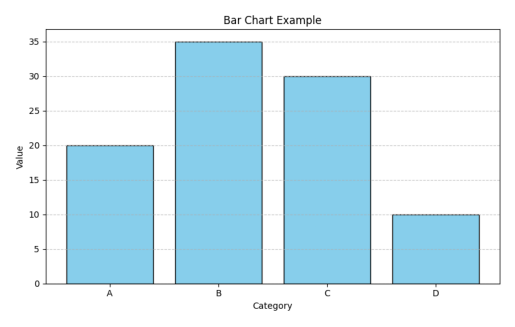

type: bar
title: Bar Chart Example
x_label: Category
y_label: Value
elements:

	label: A
	group: _container0
	value: 20

	label: B
	group: _container0
	value: 35

	label: C
	group: _container0
	value: 30

	label: D
	group: _container0
	value: 10


In [ ]:
code = """
import matplotlib.pyplot as plt

# Data
categories = ['A', 'B', 'C', 'D']
values = [20, 35, 30, 10]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Bar Chart Example')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
"""

response = sandbox.process.code_run(code)
chart = response.artifacts.charts[0]

img_data = base64.b64decode(chart.png)
img = plt.imread(io.BytesIO(img_data))
plt.imshow(img)
plt.axis("off")
plt.show()

print(f"type: {chart.type}")
print(f"title: {chart.title}")
if isinstance(chart, BarChart):
    print(f"x_label: {chart.x_label}")
    print(f"y_label: {chart.y_label}")
    print("elements:")
    for element in chart.elements:
        print(f"\n\tlabel: {element.label}")
        print(f"\tgroup: {element.group}")
        print(f"\tvalue: {element.value}")


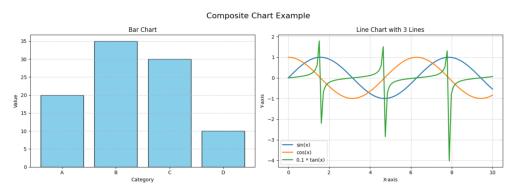

type: composite_chart
title: Composite Chart Example

	type: bar
	title: Bar Chart
	x_label: Category
	y_label: Value
	elements:

		label: A
		group: _container0
		value: 20

		label: B
		group: _container0
		value: 35

		label: C
		group: _container0
		value: 30

		label: D
		group: _container0
		value: 10

	type: line
	title: Line Chart with 3 Lines
	x_label: X-axis
	y_label: Y-axis
	x_ticks: [-2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
	x_tick_labels: ['−2', '0', '2', '4', '6', '8', '10', '12']
	x_scale: linear
	y_ticks: [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
	y_tick_labels: ['−5', '−4', '−3', '−2', '−1', '0', '1', '2', '3']
	y_scale: linear
	elements:

		label: sin(x)
		points: [[0.0, 0.0], [0.10101010101010101, 0.1008384202581046], [0.20202020202020202, 0.2006488565226854], [0.30303030303030304, 0.2984138044476411], [0.40404040404040403, 0.3931366121483298], [0.5050505050505051, 0.48385164043793466], [0.6060606060606061, 0.5696341069089657], [0.7070707070707071, 0.64960

In [ ]:
code = """
import matplotlib.pyplot as plt
import numpy as np

# Data for bar chart
categories = ['A', 'B', 'C', 'D']
bar_values = [20, 35, 30, 10]

# Data for line chart
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x) * 0.1  # scaled to fit nicely

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Bar Chart (subplot 1) ---
ax1.bar(categories, bar_values, color='skyblue', edgecolor='black')
ax1.set_title('Bar Chart')
ax1.set_xlabel('Category')
ax1.set_ylabel('Value')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --- Line Chart with 3 lines (subplot 2) ---
ax2.plot(x, y1, label='sin(x)', linewidth=2)
ax2.plot(x, y2, label='cos(x)', linewidth=2)
ax2.plot(x, y3, label='0.1 * tan(x)', linewidth=2)
ax2.set_title('Line Chart with 3 Lines')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Add main title
fig.suptitle('Composite Chart Example', fontsize=16)

# Adjust layout and show
plt.tight_layout()
plt.show()
"""

response = sandbox.process.code_run(code)
chart = response.artifacts.charts[0]

img_data = base64.b64decode(chart.png)
img = plt.imread(io.BytesIO(img_data))
plt.imshow(img)
plt.axis("off")
plt.show()

print(f"type: {chart.type}")
print(f"title: {chart.title}")
if isinstance(chart, CompositeChart):
    for subplot in chart.elements:
        print(f"\n\ttype: {subplot.type}")
        print(f"\ttitle: {subplot.title}")
        if isinstance(subplot, BarChart):
            print(f"\tx_label: {subplot.x_label}")
            print(f"\ty_label: {subplot.y_label}")
            print("\telements:")
            for element in subplot.elements:
                print(f"\n\t\tlabel: {element.label}")
                print(f"\t\tgroup: {element.group}")
                print(f"\t\tvalue: {element.value}")
        elif isinstance(subplot, LineChart):
            print(f"\tx_label: {subplot.x_label}")
            print(f"\ty_label: {subplot.y_label}")
            print(f"\tx_ticks: {subplot.x_ticks}")
            print(f"\tx_tick_labels: {subplot.x_tick_labels}")
            print(f"\tx_scale: {subplot.x_scale}")
            print(f"\ty_ticks: {subplot.y_ticks}")
            print(f"\ty_tick_labels: {subplot.y_tick_labels}")
            print(f"\ty_scale: {subplot.y_scale}")
            print("\telements:")
            for element in subplot.elements:
                print(f"\n\t\tlabel: {element.label}")
                print(f"\t\tpoints: {element.points}")

In [ ]:
# List files in the sandbox
files = sandbox.fs.list_files("~")
pp(files)

# Create a new directory in the sandbox
new_dir = "new-dir"
sandbox.fs.create_folder(new_dir, "755")

file_path = os.path.join(new_dir, "data.txt")

# Add a new file to the sandbox
file_content = b"Hello, World!"
sandbox.fs.upload_file(file_content, file_path)

# Search for the file we just added
matches = sandbox.fs.find_files("~", "World!")
pp(matches)

# Replace the contents of the file
sandbox.fs.replace_in_files([file_path], "Hello, World!", "Goodbye, World!")

# Read the file
downloaded_file = sandbox.fs.download_file(file_path)
print("File content:", downloaded_file.decode("utf-8"))

# Change the file permissions
sandbox.fs.set_file_permissions(file_path, mode="777")

# Get file info
file_info = sandbox.fs.get_file_info(file_path)
pp(file_info)  # Should show the new permissions

# Move the file to the new location
new_file_path = "moved-data.txt"
sandbox.fs.move_files(file_path, new_file_path)

# Find the file in the new location
search_results = sandbox.fs.search_files("~", "moved-data.txt")
pp(search_results)

# Delete the file
sandbox.fs.delete_file(new_file_path)

[FileInfo(name='.bash_logout', is_dir=False, size=220, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.bashrc', is_dir=False, size=3526, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.cache', is_dir=True, size=24, mod_time='2025-05-25 06:42:39.954454234 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.config', is_dir=True, size=24, mod_time='2025-05-25 06:42:39.757457289 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.daytona', is_dir=True, size=22, mod_time='2025-05-25 06:40:00.918908951 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.profile', is_dir=False,

In [ ]:
project_dir = "learn-typescript"

# Clone the repository
sandbox.git.clone("https://github.com/panaverse/learn-typescript", project_dir, "master")

sandbox.git.pull(project_dir)

branches = sandbox.git.branches(project_dir)
pp(branches)

ListBranchResponse(branches=['master'], additional_properties={})


In [ ]:
sandboxes = daytona.list()
print(f"Total sandboxes count: {len(sandboxes)}")

for s in sandboxes:
    print(s.id)
    pp(s.info())
    print()

Total sandboxes count: 1
395b2244-9177-43e7-a4f7-7ee3bf8653a4
SandboxInfo(created='2025-05-25T06:39:59.879Z', name='', provider_metadata='{"state":"started","nodeDomain":"h1091.daytona.work","region":"us","class":"small","updatedAt":"2025-05-25T06:44:49.396Z","lastSnapshot":"2025-05-25T06:42:30.105Z","cpu":2,"gpu":0,"memory":4,"disk":10,"autoStopInterval":15}', additional_properties={}, id='395b2244-9177-43e7-a4f7-7ee3bf8653a4', image='daytonaio/sandbox:0.3.0', user='daytona', env={}, labels={}, public=False, target=<SandboxTargetRegion.US: 'us'>, resources=SandboxResources(cpu='2', memory='4Gi', disk='10Gi', gpu=None), state=<WorkspaceState.STARTED: 'started'>, error_reason=None, snapshot_state='Completed', snapshot_created_at='2025-05-25T06:42:30.105Z', node_domain='h1091.daytona.work', region='us', class_name='small', updated_at='2025-05-25T06:44:49.396Z', last_snapshot='2025-05-25T06:42:30.105Z', auto_stop_interval=15)



In [ ]:
# daytona.stop(sandbox)
# daytona.start(sandbox)
# daytona.delete(sandbox)

# NEW

In [ ]:
import base64
import io
import os
from pprint import pp

import matplotlib.pyplot as plt
from daytona_sdk import BarChart, CompositeChart, Daytona, LineChart, SessionExecuteRequest,DaytonaConfig

config = DaytonaConfig(api_key="dtn_619a563e2590c5bedea5ad135ce64d22ef76fd2b703fd6d44f7b94bedcd7c872")

daytona = Daytona(config)

In [ ]:
# Define the details for the new image you want to register
image_name_to_register = "docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik"
image_description = "Openhands AI Runtime 0.39 Nikolaik"

try:
    # Create a CreateImage object with the required details
    new_image_data = CreateImage(
        name=image_name_to_register,
        description=image_description,
        # registry_id is optional, if your image is from a public registry like Docker Hub
        # or a registry pre-configured with Daytona, you might not need to specify it.
        # If it's a private registry not yet configured, you'd need to set that up first.
        # For this example, we assume it's publicly accessible or already handled by Daytona's backend.
        # visibility="public" # Uncomment if you want to explicitly set visibility
    )

    print(f"Attempting to register image: {image_name_to_register}")
    registered_image = daytona.images.create_image(new_image_data)
    print(f"Image '{registered_image.name}' registered successfully with ID: {registered_image.id}")
    print(f"Image State: {registered_image.state}") # Expecting state like 'READY' or 'BUILDING'
#except DaytonaError as e:
#    print(f"Daytona Error registering image: {e.message}")
except Exception as e:
    print(f"An unexpected error occurred during image registration: {e}")

An unexpected error occurred during image registration: name 'CreateImage' is not defined


In [ ]:
# Create a sandbox, specifying the Openhands Docker image as the runtime
try:
    openhands_docker_image = "docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik"
    print(f"Creating sandbox with image: {openhands_docker_image}")
    sandbox = daytona.create(image=openhands_docker_image)
    print(f"Sandbox created successfully with ID: {sandbox.id}")
except Exception as e:
    print(f"Error creating sandbox: {e}")
    sandbox = None

Creating sandbox with image: docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik
Error creating sandbox: Failed to create sandbox: Daytona.create() got an unexpected keyword argument 'image'


In [ ]:
params = CreateSandboxParams(
    language="python",
    image="

/bin/bash: line 1: daytona: command not found


In [ ]:
if False:
  mount_dir_1 = "/home/daytona/volume"
  import os

  volume = daytona.volume.get("docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik", create=True)
  from daytona_sdk import CreateSandboxParams, Daytona, VolumeMount

  params = CreateSandboxParams(
      language="python",
      volumes=[VolumeMount(volumeId=volume.id, mountPath=mount_dir_1)],
  )
  sandbox = daytona.create(params)
  daytona.delete(sandbox)

In [ ]:
# List files in the mount directory
files = sandbox.fs.list_files(mount_dir_1)
print("Files:", files)


Files: []


In [ ]:
daytona.delete(sandbox)

In [ ]:
try:
    sandbox = daytona.create()
    print(f"Sandbox created with ID: {sandbox.id}")
except Exception as e:
    print(f"Error creating sandbox: {e}")
    sandbox = None

Sandbox created with ID: b26a4272-3aea-4a72-aa41-40439f97c292


In [ ]:
if sandbox:
    try:
        docker_pull_command = "docker pull docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik"
        print(f"Executing: {docker_pull_command}")
        response = sandbox.process.exec(docker_pull_command, timeout=300) # Increased timeout for pull
        if response.exit_code != 0:
            print(f"Error pulling Docker image: {response.exit_code} {response.result}")
        else:
            print(f"Docker image pull successful: {response.result}")
    except Exception as e:
        print(f"Error during Docker pull: {e}")

Executing: docker pull docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik
Error pulling Docker image: 127 sh: 1: docker: not found



In [ ]:
if sandbox:
    try:
        docker_run_command = (
            "docker run -it --rm --pull=always "
            "-e SANDBOX_RUNTIME_CONTAINER_IMAGE=docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik "
            "-e LOG_ALL_EVENTS=true "
            "-v /var/run/docker.sock:/var/run/docker.sock "
            "-v ~/.openhands-state:/.openhands-state "
            "-p 3000:3000 "
            "--add-host host.docker.internal:host-gateway "
            "--name openhands-app "
            "docker.all-hands.dev/all-hands-ai/openhands:0.39"
        )
        print(f"Executing: {docker_run_command}")
        response = sandbox.process.exec(docker_run_command, timeout=300) # Increased timeout for run
        if response.exit_code != 0:
            print(f"Error running Docker container: {response.exit_code} {response.result}")
        else:
            print(f"Docker container started: {response.result}")
    except Exception as e:
        print(f"Error during Docker run: {e}")

Executing: docker run -it --rm --pull=always -e SANDBOX_RUNTIME_CONTAINER_IMAGE=docker.all-hands.dev/all-hands-ai/runtime:0.39-nikolaik -e LOG_ALL_EVENTS=true -v /var/run/docker.sock:/var/run/docker.sock -v ~/.openhands-state:/.openhands-state -p 3000:3000 --add-host host.docker.internal:host-gateway --name openhands-app docker.all-hands.dev/all-hands-ai/openhands:0.39
Error running Docker container: 127 sh: 1: docker: not found



In [ ]:
if sandbox:
    try:
        # Example: List files in the sandbox to confirm setup
        files = sandbox.fs.list_files("~")
        print("Files in sandbox home directory:")
        pp(files)
    except Exception as e:
        print(f"Error listing files in sandbox: {e}")

Files in sandbox home directory:
[FileInfo(name='.bash_logout', is_dir=False, size=220, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.bashrc', is_dir=False, size=3526, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.daytona', is_dir=True, size=4096, mod_time='2025-05-25 07:18:18.872801551 +0000 UTC', mode='drwxr-xr-x', permissions='0755', owner='1001', group='1001', additional_properties={}),
 FileInfo(name='.profile', is_dir=False, size=807, mod_time='2024-03-29 19:40:10 +0000 UTC', mode='-rw-r--r--', permissions='0644', owner='1001', group='1001', additional_properties={})]


In [ ]:
if sandbox:
    try:
        # Clean up: Stop and delete the sandbox when done
        print(f"Stopping sandbox {sandbox.id}...")
        daytona.stop(sandbox)
        print(f"Sandbox {sandbox.id} stopped.")

        print(f"Deleting sandbox {sandbox.id}...")
        daytona.delete(sandbox)
        print(f"Sandbox {sandbox.id} deleted.")
    except Exception as e:
        print(f"Error during sandbox cleanup: {e}")

Stopping sandbox 92004df4-f0ad-4627-81ba-1f86bbeed2de...
Error during sandbox cleanup: Failed to stop sandbox: Workspace is not started
